In [296]:
#  displays plots directly in this notebook as images
%matplotlib inline
import numpy as np       # the NumPy library for fast matrix and vector data types and math operations
import matplotlib.pyplot as plt   # functions for plotting, loaded under a convenient name alias 'plt'
import xarray as xr      # matrix and vector containers with labeled axes, used for signals
import holoviews as hv   # a different plotting web-based library mainly for interactive display
import hvplot.xarray     # xaray wrappers for holoviews
import xrscipy           # additional SciPy xarray-compatible wrappers
import xrscipy.signal as dsp    # subpackage convenience: functions for digital signal processing of signals
import xrrandom          # for random sammpling parametrized by xarray objects
import cdb_extras.xarray_support as cdbxr  # a convenient Python library for accessing the COMPASS database

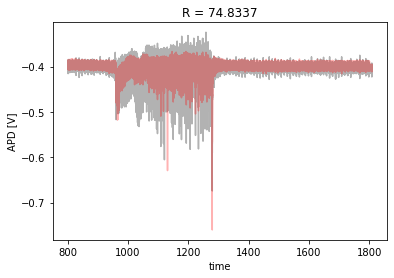

In [297]:
# Miklós suggested using Mirnov A 2 signals (closest to the Li-beam), for the APD signal we must check the separatrix

shot = cdbxr.Shot(18447)

shot.APD[:,14].plot(c='k', alpha=.3)
shot.APD[:,16].plot(c='r', alpha=.3)

(1099.99, 1100.01)

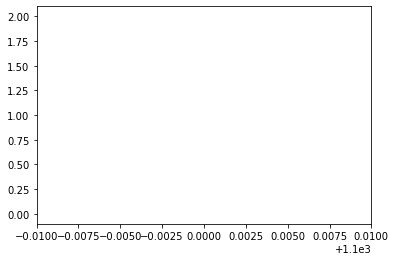

In [295]:
# the time series need to be defined on the same time steps
time_APD = shot['APD.light_profile'].sel(time=slice(START, END)).time
time_Mirnov = shot['Mirnov_A_rad_02_RAW'].sel(time=slice(START, END)).time
dt_min = max(np.diff(time_APD).min(), np.diff(time_Mirnov).min())


plt.scatter(time_APD, np.ones(time_APD.shape)+1, c='r')
plt.scatter(time_Mirnov, np.ones(time_Mirnov.shape), c='b')

N_TIME_STEPS = 50000
time_common = np.linspace(START, END, N_TIME_STEPS)
#assert np.diff(time_common).min() > dt_min


plt.scatter(time_common, np.ones(time_common.shape)-1, c='g')

plt.xlim(1099.99, 1100.01)

In [285]:
def time_series_average(time_arr, signal_arr, time_step):
    start, end = time_arr[0], time_arr[-1]
    assert len(time_arr) == len(signal_arr)
    assert len(time_arr) > (end - start) / time_step, 'too short time_step!'
    
    time = np.arange(start, end-time_step, time_step)    
    signal_ave = [signal_arr[(t<=time_arr)&(time_arr<t+time_step)].mean() for t in time]
    #time += time_step / 2
    
    return time, signal_ave
        

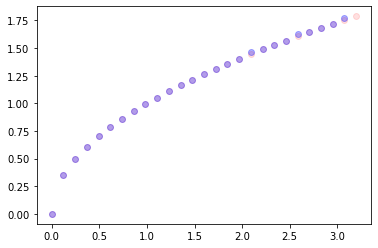

In [286]:
t=np.arange(0, 3.3123, .123)
s=np.sqrt(t)
plt.scatter(t, s, c='r', alpha=.123)

tt, ss = time_series_average(t, s, .123)

plt.scatter(tt, ss, c='b', alpha=.3)


0.0005000000001018634
0.0009138967560146315 -0.0007116404342850957


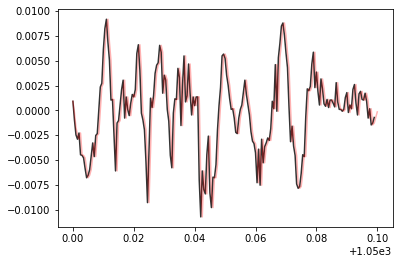

In [263]:
START = 1050
END = 1050.1

signal_Mirnov = shot.Mirnov_A_rad_02_RAW.sel(time=slice(START, END)).data
time_Mirnov = shot['Mirnov_A_rad_02_RAW'].sel(time=slice(START, END)).time
print(float(time_Mirnov[1] - time_Mirnov[0]))

t, s = time_series_average(time_Mirnov, signal_Mirnov, .0005)

plt.plot(t, s, c='k', alpha=.8)
plt.plot(time_Mirnov, signal_Mirnov, c='r', alpha=.3)

print(s[0], s[-1])

1050.0032618745172


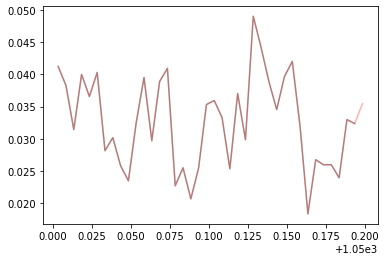

In [264]:
START = 1050
END = 1050.2


signal_APD = shot['APD.light_profile'].sel(time=slice(START, END)).data[:,14]
time_APD = shot['APD.light_profile'].sel(time=slice(START, END)).time



t, s = time_series_average(time_APD, signal_APD, 0.005)

print(t[0])

plt.plot(time_APD, signal_APD, c='r', alpha=.3)
plt.plot(t, s, c='k', alpha=.3)


In [307]:
# Code from previous year, sent to us by Miklós

from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.ar_model import AutoReg
from scipy.stats import f


import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.ar_model.AR', FutureWarning)

def get_gcc(x, y, d=2):
    """Computes F value wether y Granger causes x

    :param numpy.ndarray x: target array shape (1D)
    :param numpy.ndarray y: source array (1D)
    :param int d: maxlag of autoregression
    :return: log(F) value for y -> x
    :rtype: float

    """
    T = len(x)

    # for definition of AR => (https://en.wikipedia.org/wiki/Autoregressive_model#Definition)
    ar = AutoReg(x, d)
    ar_fit = ar.fit()
    var = VAR(np.array([x, y]).T)
    var_fit = var.fit()
  #  print(var_fit.summary())
   
    return np.log(ar_fit.resid.var() / var_fit.resid.var(axis=0)[0])


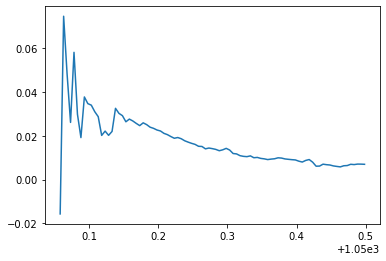

In [315]:
START = 1050
END = 1070
dt = .005

signal_APD = shot['APD.light_profile'].sel(time=slice(START, END)).data[:,14]
time_APD = shot['APD.light_profile'].sel(time=slice(START, END)).time
t_APD, s_APD = time_series_average(time_APD, signal_APD, dt)


signal_Mirnov = shot.Mirnov_A_rad_02_RAW.sel(time=slice(START, END)).data
time_Mirnov = shot['Mirnov_A_rad_02_RAW'].sel(time=slice(START, END)).time
t_Mirnov, s_Mirnov = time_series_average(time_APD, signal_APD, dt)



coeffs_granger = []
time_granger = []

for n in range(100):
    

    if n > 10:
        coeffs_granger.append(get_gcc(s_Mirnov[:n], s_APD[:n]))
        time_granger.append(t_APD[n])
    
plt.plot(time_granger, coeffs_granger)


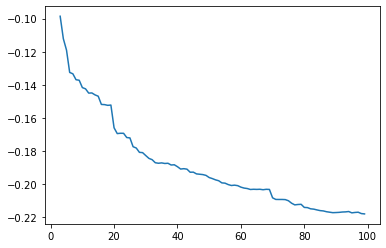

In [318]:
coeffs_granger = []
time_granger = []

for n in range(100):
    

    if n > 2:
        coeffs_granger.append(get_gcc(s_Mirnov, s_APD, d=n))
        time_granger.append(n)
    
plt.plot(time_granger, coeffs_granger)